In [2]:
# added some comments, trying to commit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

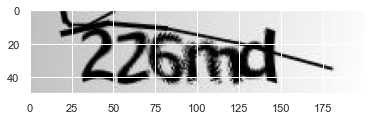

In [2]:
# checking out ana example of image from the dataset
img = plt.imread("Kaggle_Captcha_data/226md.png")
plt.imshow(img)

In [119]:
# getting the names of all files and looking at all
# possible target variable values (answers to the CAPTCHA)
files = os.scandir("Kaggle_Captcha_data")
files = [i.name for i in files]

all_symbols = ""
for i in range(len(files)):
    all_symbols += files[i].split(".")[0]
    
uniques = list(set(all_symbols))  
print(f"All unique target symbols: {uniques}\n")

encoding_dict = {}
for i in range(len(uniques)):
    encoding_dict[uniques[i]] = i
    
print(f"Numerical encoding of each character: {encoding_dict}")

All unique target symbols: ['n', 'g', 'e', '8', 'w', 's', 'm', 'y', 'f', 'd', '6', '7', 'a', '2', '3', '5', 'b', '4', 'x', 'c', 'l', 'p']

Numerical encoding of each character: {'n': 0, 'g': 1, 'e': 2, '8': 3, 'w': 4, 's': 5, 'm': 6, 'y': 7, 'f': 8, 'd': 9, '6': 10, '7': 11, 'a': 12, '2': 13, '3': 14, '5': 15, 'b': 16, '4': 17, 'x': 18, 'c': 19, 'l': 20, 'p': 21}


In [120]:
# building a DataFrame with all the information about the dataset
data = pd.DataFrame(columns=["filename", "label", "char1", 
                             "char2", "char3", "char4", "char5"])
for entry in range(len(files)):
    data.loc[entry, "filename"] = files[entry]
    data.loc[entry, "label"] = files[entry].split(".")[0]
    data.loc[entry, "char1"] = files[entry][0]
    data.loc[entry, "char2"] = files[entry][1]
    data.loc[entry, "char3"] = files[entry][2]
    data.loc[entry, "char4"] = files[entry][3]
    data.loc[entry, "char5"] = files[entry][4]

print(data.shape)
index = list(data[data["filename"] == "samples"].index)[0]
data = data.drop(index, axis=0)
data.reset_index(drop=True, inplace=True)
data.head()

(1071, 7)


,filename,label,char1,char2,char3,char4,char5
0,226md.png,226md,2,2,6,m,d
1,22d5n.png,22d5n,2,2,d,5,n
2,2356g.png,2356g,2,3,5,6,g
3,23mdg.png,23mdg,2,3,m,d,g
4,23n88.png,23n88,2,3,n,8,8


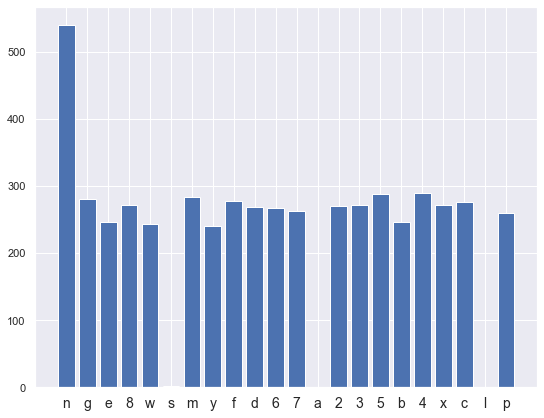

In [121]:
# getting the values count to understand the target 
# variable distribution
counts_dict = {}
for char in set(all_symbols):
    counts_dict[char] = all_symbols.count(char)
    
plt.figure(figsize=(9, 7))
plt.bar(counts_dict.keys(), counts_dict.values())
plt.xticks(size=14)
plt.show()

# the distribution shows only one occurence of "s", "l" and "a"
# they are coming from the folder named "samples" which
# I forgot to remove from the destination prior to training
# I realized it only after I have trained the entire model
# so I will keep these variables in here since they do not harm performance

In [122]:
# shaping X and y sets
def prepare_data(df, test_proportion, 
                encoding_dict, crop=True):
    """
    Prepare and split data to train vs. valid
    
    Arguments:
    ----------
    df : pd.DataFrame -- all image data organized into the dataframe
    test_proportion : float -- portion of entries to allocate for validation
    encoding_dict : dict -- contains numerical encoding for each variable
    
    Returns:
    -------
    X_train, X_valid : ndarray (m, 50, 200, 1) -- image pixel values
    y_train, y_valid : ndarray (m, 22 * 5) -- true picture encoding
    """
    
    np.random.seed(0)
    
    X, y = [], []
    for i in range(df.shape[0]):
        
        # creating X entry
        path = "Kaggle_Captcha_data/" + df.loc[i, "filename"]
        img = tf.io.read_file(path)
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        
        if crop:
            # cropping the image to zoom in on letters
            # (removing useless "white" data on image sides)
            img = tf.image.crop_to_bounding_box(img, offset_height=0,
                                           offset_width=25,
                                           target_height=50,
                                           target_width=125)
            # images might have different size after cropping
            # thus resizing to ensure equal size for all images
            img = tf.image.resize(img, size=[50, 200], 
                                  method="bilinear",
                                  preserve_aspect_ratio=False,
                                  antialias=False,
                                  name=None)
        X.append(img)
        
        # getting the label of the corresponding image 
        label = np.array([encoding_dict[x] for x in df.loc[i, "label"]])
        
        # to ensure proper learning for the CNN, we will encode the
        # target variable using one-hot encoding.
        # since all the answers contain exactly 5 symbols, we encode
        # them into one-hot matrix with shape (total_unique_characters, 5)
        onehot = np.zeros((max(encoding_dict.values())+1, label.size))
        cols = np.arange(label.size)
        onehot[label, cols] = 1
        # flattening the matrix to allow the CNN to learn
        y.append(onehot.flatten(order="F"))
    
    # splitting to train vs. valid
    test_indices = np.random.randint(0, df.shape[0], 
                                     int(df.shape[0] * test_proportion))
    
    X_valid = [X[i] for i in test_indices]
    y_valid = [y[i] for i in test_indices]
    
    X_train = [X[i] for i in range(len(X)) if i not in test_indices]
    y_train = [y[i] for i in range(len(y)) if i not in test_indices]
    
    # reshaping to contain the number of images (m) as the first dimension
    X_train = np.array(X_train).reshape(-1, 50, 200, 1)
    X_valid = np.array(X_valid).reshape(-1, 50, 200, 1)
    y_train = np.array(y_train)
    y_valid = np.array(y_valid)
    
    return X_train, X_valid, y_train, y_valid

X_train, X_valid, y_train, y_valid = prepare_data(df=data,
                                                 test_proportion=0.05,
                                                 encoding_dict=encoding_dict)

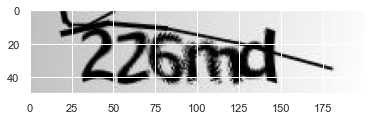

Shape of the image: (50, 200, 1)

After converting type to float and reading with 1 channel.


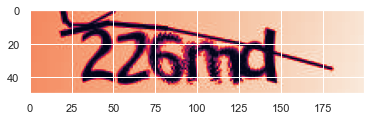

After cropping to bounding box.


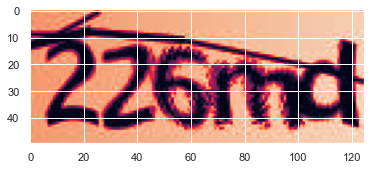

After resizing the image


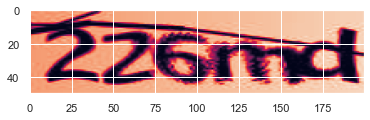

In [123]:
# showcasing the transformations on the image 
# when it goes through preprocessing
plt.imshow(img)
plt.show()
temp_img = tf.io.read_file("Kaggle_Captcha_data/226md.png")
img2 = tf.io.decode_png(temp_img, channels=1)
print(f"Shape of the image: {img2.shape}\n")

img2 = tf.image.convert_image_dtype(img2, tf.float32)
print("After converting type to float and reading with 1 channel.")
plt.imshow(img2)
plt.show()

img2 = tf.image.crop_to_bounding_box(img2, offset_height=0,
                                           offset_width=25,
                                           target_height=50,
                                           target_width=125)
print("After cropping to bounding box.")
plt.imshow(img2)
plt.show()

img2 = tf.image.resize(img2, size=[50, 200], method="bilinear",
                                 preserve_aspect_ratio=False,
                                 antialias=False,
                                 name=None)
print("After resizing the image")
plt.imshow(img2)
plt.show()

In [42]:
# datagenerator to increase the number of training examples
# and ensure we cover some edge-cases (weird angles and cropped letters)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=15,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.07, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [116]:
# constructing CNN architecture
model = keras.Sequential([
    layers.Conv2D(filters=16, kernel_size=(3, 3), 
                activation="relu", input_shape=(50, 200, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    
    layers.Conv2D(filters=128, kernel_size=(2, 2), activation="relu"),
    
    layers.Flatten(),
    
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.3),
    
    layers.Dense(units=256, activation="relu"),
    layers.Dropout(0.25),
    
    layers.Dense(units=110, activation="sigmoid")
])

# using Adam to increase the efficiency of the Gradient Descent
model.compile(optimizer="Adam",
             loss="binary_crossentropy")


# stopping if no progress for 60 epochs
# and restoring the best validation weights
early_stopping = callbacks.EarlyStopping(patience=60,
                                        monitor="val_loss",
                                        min_delta = 0.003,
                                        verbose=2,
                                        restore_best_weights=True)

# decreasing the learning rate when the training loss stops decreasing
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                            factor=0.8, 
                                            patience=4, 
                                            verbose=1,
                                            mode='min', 
                                            restore_best_weights=True)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 48, 198, 16)       160       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 99, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 22, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 11, 48, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 9, 46, 64)         18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 45, 128)        32896     
_________________________________________________________________
flatten_6 (Flatten)          (None, 46080)            

In [ ]:
# fitting the model, it'll take about an hour to learn with these parameters
# and the val_loss should be just below 0.04

# you can skip training by loading this model after training (2 cells below)
training = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    validation_data=(X_valid, y_valid),
                    epochs=400,
                    callbacks=[early_stopping, plateau])


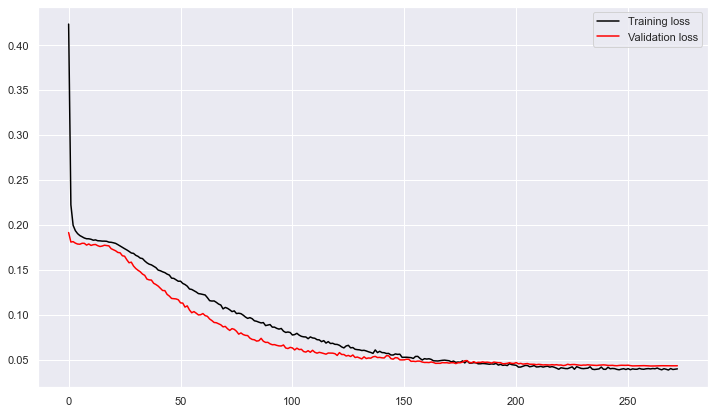

Number of epochs trained: 273
Training loss: 0.04,	 validation_loss:0.0435


In [115]:
model_df = pd.DataFrame(training.history)

def plot_performance(data):
    loss = np.array(data["loss"])
    val_loss = np.array(data["val_loss"])
    
    plt.figure(figsize=(12, 7))
    plt.plot(loss, label="Training loss", color="black")
    plt.plot(val_loss, label="Validation loss", color="red")
    plt.legend()
    plt.show()
    print(f"Number of epochs trained: {len(loss)}")
    print(f"Training loss: {round(loss[-1], 4)},\t validation_loss:{round(val_loss[-1], 4)}")

plot_performance(model_df)

In [117]:
model = keras.models.load_model("model91")

In [126]:
# evaluating the model performance here
def reshape_preds(preds):
    """
    Reshape flattened vectors into (22, 5) matrices
    and get the predicted indices
    
    Arguments:
    ---------
    preds : ndarray -- probabilities of characters in
                    individual CAPTCHA pictures
                    
    Returns:
    -------
    new_preds : ndarray -- encoding of most likely variables
    """
    new_preds = []
    for prediction in range(len(preds)):
        temp = preds[prediction]
        reshaped = np.array([temp[:22],
                             temp[22:44],
                             temp[44:66],
                             temp[66:88],
                             temp[88:110]]).T
        new_preds.append(np.array(np.argmax(reshaped, axis=0)))
    return new_preds


def accuracy(prediction, truth):
    """
    Assess the accuracy of prediction on a single image
    """
    if prediction.shape == truth.shape:
        return np.sum(prediction == truth) / truth.shape[0]
    raise Exception(f"Size of prediction and truth does not match "+
                    f"{prediction.shape} vs {truth.shape}.")
    
    
def assess_model(model, X_valid, y_valid):
    """
    Assess the overall model accuracy
    """
    preds = model.predict(X_valid)

    predictions = reshape_preds(preds)
    validations  = reshape_preds(y_valid)

    accuracies = []
    for i in range(len(predictions)):
        accuracies.append(accuracy(predictions[i], validations[i]))

    return accuracies, predictions, validations

# we can use X_valid and y_valid for assessment, but, to get a fuller view
# we can also look at the performance on the entire dataset
X = np.concatenate((X_train, X_valid), axis=0)
y = np.concatenate((y_train, y_valid), axis=0)
accuracies, predictions, validations = assess_model(new_model, X, y)

# we can observe an almost perfect accuracy
print(np.mean(accuracies))

0.9958993476234854


In [128]:
def decode_label(label, encoding_dict):
    alternative_dict = {value:key for key, value in encoding_dict.items()}
    result = ""
    for i in label:
        result += alternative_dict[i]
        
    return result

# evaluating predictions by looking at the outputs
example = 225
temp_label = decode_label(predictions[example], encoding_dict)
temp_true  = decode_label(validations[example], encoding_dict)
print(f"Predicted label for the single CAPTCHA: {temp_label}")
print(f"Actual label for the same CAPTCHA:      {temp_true}")

Predicted label for the single CAPTCHA: 6bnnm
Actual label for the same CAPTCHA:      6bnnm
